整理自  https://hrl.boyuai.com/chapter/3/%E6%A8%A1%E4%BB%BF%E5%AD%A6%E4%B9%A0


<font size=5>**生成式对抗模仿学习**</font>

生成式对抗网络的本质其实就是模仿学习

占用度量： 在某个状态下执行动作的概率分布

策略 $\pi$： 生成式对抗网络中的生成器，给定一个状态，策略会输出这个状态下应该采取的动作。

判别器： 判断状态-动作对 $(s,a)$ 是来自 agent 还是 专家。




<img src="https://i-blog.csdnimg.cn/direct/507bf70095774281a65524da26f91b5d.png" width="700">

<mark>agent 的奖励   $~~r(s,a)=-\log D(s,a)$</mark>




## 获取专家数据

我们需要有一定量的专家数据，为此，预先通过 PPO 算法训练出一个表现良好的专家模型，再**利用专家模型生成专家数据。**

### 训练 PPO-Clip agent

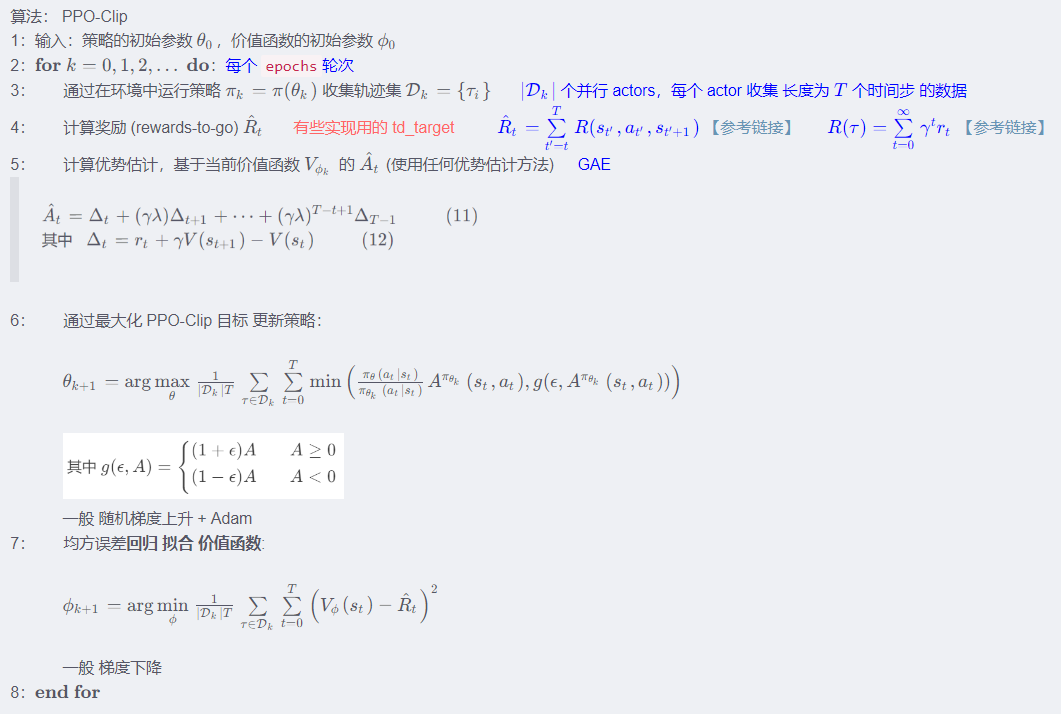

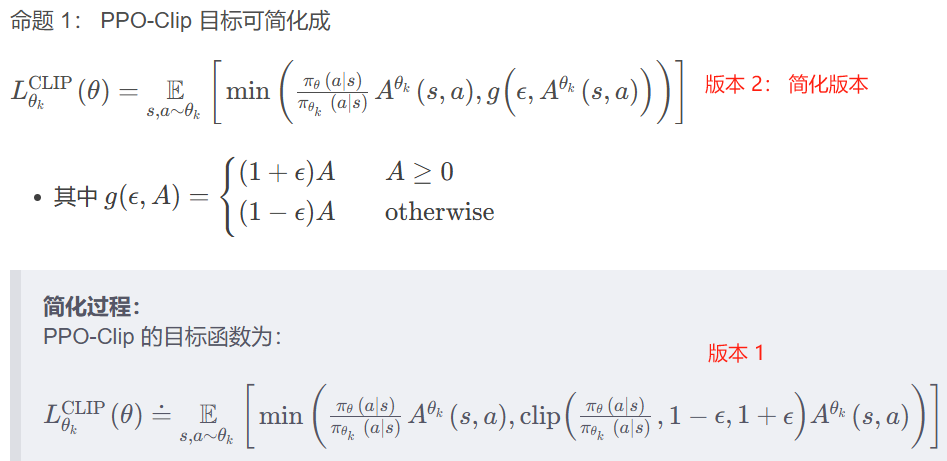

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 7.5 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random # 采样专家 的 状态-动作 对
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

#### —— 辅助代码模块

In [3]:
# rl_utils.compute_advantage https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py
### 计算 优势 GAE

def computer_advantage(γ, λ, Δts):  # TD 误差
  Δts = Δts.detach().numpy() # 提高计算速度
  advantage_list = []
  advantage = 0.0
  for delta in Δts[::-1]:  # T-1, ...,
    advantage = γ * λ * advantage + delta
    advantage_list.append(advantage)
  advantage_list.reverse()
  return torch.tensor(advantage_list,dtype=torch.float)

#### actor + critic + agent  代码模块

In [4]:
### 策略 的 神经网络 (actor)
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return F.softmax(self.fc2(x), dim=1) # p(a_i|s)


### 价值函数 的神经网络 (critic)
class ValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x) # Q 值


### PPO-Clip 算法 (agent)
class PPOClip:
  """ PPO-Clip 算法 """
  def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, epsilon, gamma, device):
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.gamma = gamma # 折扣因子 γ
    self.lmbda = lmbda  # 优势估计 GAE 的 λ
    self.epochs = epochs  # 训练轮次 K   完整数据集 经过 神经网络的次数
    self.epsilon = epsilon  # PPO-Clip 目标里的超参数 ε
    self.device = device

  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action = torch.distributions.Categorical(probs).sample().item()
    return action

  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    td_delta = td_target - self.critic(states)  # Δt = r_t + γ V(s_{t+1}) - V(s_t)
    advantage = computer_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)  # 计算 优势 A_t
    old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach() # 先取 log 后取 e^x 求除法有什么好处呢

    for _ in range(self.epochs): # K
      log_probs = torch.log(self.actor(states).gather(1, actions))
      ratio = torch.exp(log_probs - old_log_probs) # 裁剪概率比
      surr1 = ratio * advantage  # 前一项
      surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage  # 后一项  版本 1

      actor_loss = torch.mean(-torch.min(surr1, surr2))
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      self.actor_optimizer.step()

      critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

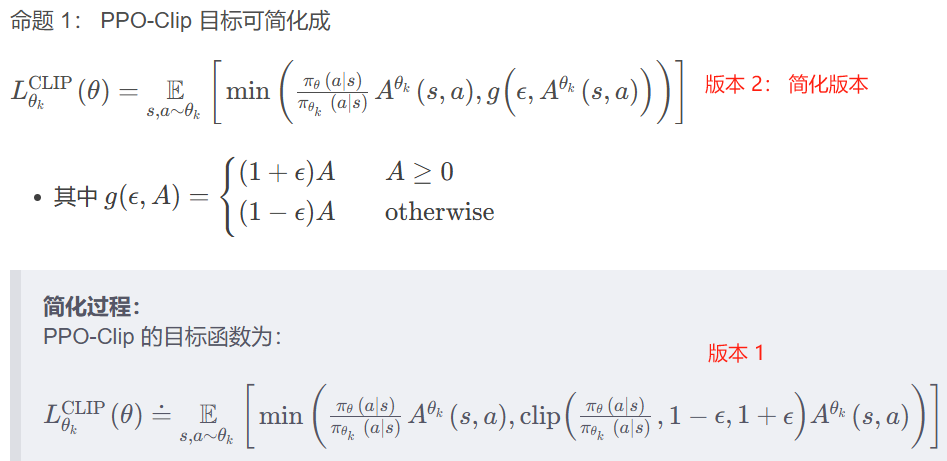

##### seed 筛选 (可跳过)

In [5]:
print(YES)

NameError: name 'YES' is not defined

In [ ]:
# 训练

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98  # 折扣因子 γ
lmbda = 0.95  # 优势估计 GAE 的 λ
epochs = 10  #  K
epsilon = 0.2  # PPO-Clip 目标里的超参数 ε
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Create and wrap the environment
env_name = "CartPole-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值
# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.n

rewards_over_seeds = []

for seed in [0, 42, 20, 24, 10]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = PPOClip(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, epsilon, gamma, device)

    reward_over_episodes = []

    # on-policy同策略
    for episode in range(num_episodes):
        transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[], 'dones':[]}
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated

            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)

            state = next_state

        agent.update(transition_dict) # 回合结束更新
        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500
# https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [ ]:
import pandas as pd
import seaborn as sns

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame({"seed=0":rewards_to_plot[0],
           "seed=42":rewards_to_plot[1],
           "seed=20":rewards_to_plot[2],
           "seed=24":rewards_to_plot[3],
           "seed=10":rewards_to_plot[4],
                    })
# df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(df1).set(
    title="PPO-Clip for {}".format(env_name)
)
# 设置横轴和纵轴标签
plt.xlabel('Episodes')
plt.ylabel('Rewards')

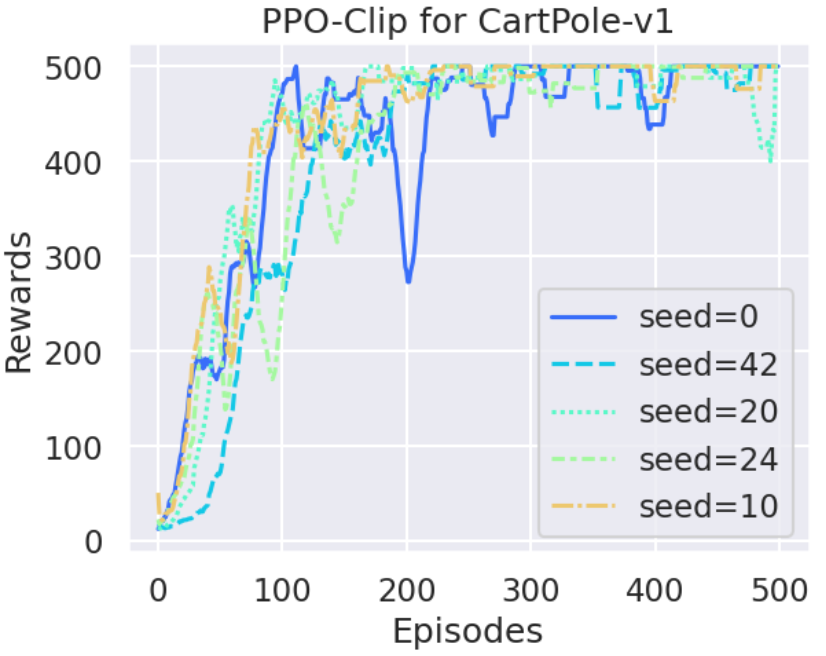

##### 训练一个 agent

In [6]:
# 训练

actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98  # 折扣因子 γ
lmbda = 0.95  # 优势估计 GAE 的 λ
epochs = 10  #  K
epsilon = 0.2  # PPO-Clip 目标里的超参数 ε
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Create and wrap the environment
env_name = "CartPole-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值
# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.n

seed = 0
# set seed
torch.manual_seed(seed)

# Reinitialize agent every seed
PPOClip_agent_seed0 = PPOClip(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, epsilon, gamma, device)

reward_over_episodes = []

# on-policy同策略
for episode in range(num_episodes):
    transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[], 'dones':[]}
    state, info = wrapped_env.reset(seed=seed)
    done = False
    while not done:
        action = PPOClip_agent_seed0.take_action(state)  # agent 改名称
        next_state, reward, terminated, truncated, info = wrapped_env.step(action)
        done = terminated or truncated

        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)

        state = next_state

    PPOClip_agent_seed0.update(transition_dict) # 回合结束更新    # 要是修改 agent 命名记得改这里
    reward_over_episodes.append(wrapped_env.return_queue[-1])

    if episode % 100 == 0:
        avg_reward = int(np.mean(wrapped_env.return_queue))
        print("Episode:", episode, "Average Reward:", avg_reward)


# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500
# https://gymnasium.farama.org/environments/classic_control/cart_pole/

Episode: 0 Average Reward: 12
Episode: 100 Average Reward: 322
Episode: 200 Average Reward: 427
Episode: 300 Average Reward: 472
Episode: 400 Average Reward: 487


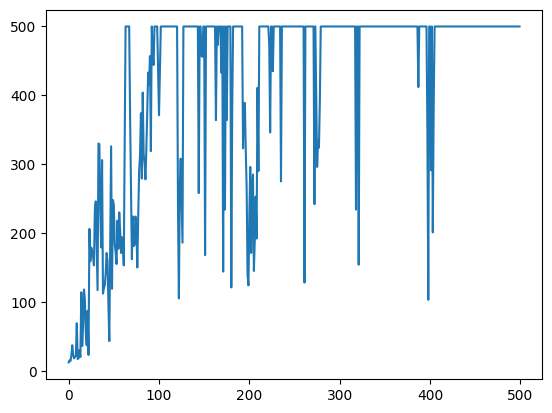

In [7]:
plt.plot(reward_over_episodes)

### 获取 状态-动作对 样本

接下来开始生成专家数据。因为车杆环境比较简单，我们只**生成一条轨迹**，并且从中**采样 30 个 状态-动作对 样本**。我们只用这 30 个专家数据样本来训练模仿策略。

In [8]:
def sample_expert_data(n_episode, seed):
  states = []
  actions = []
  for episode in range(n_episode):
    state, info = env.reset(seed=seed)  # 使用筛选的 seed
    done = False
    while not done:
      action = PPOClip_agent_seed0.take_action(state)
      states.append(state)
      actions.append(action)
      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      state = next_state
  return np.array(states), np.array(actions)


seed = 0
torch.manual_seed(seed)
random.seed(seed)
n_episode = 1
expert_s, expert_a = sample_expert_data(n_episode, seed)
print('len(expert_s): ',len(expert_s))

n_samples = 30  # 采样 30 个数据
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

len(expert_s):  500


## GAIL 算法


首先实现**判别器模型**，其模型架构为一个两层的全连接网络，模型输入为一个**状态-动作对**，输出一个**概率标量**。

In [9]:
class Discriminator(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x, a):
    cat = torch.cat([x,a], dim=1)
    x = F.relu(self.fc1(cat))
    return torch.sigmoid(self.fc2(x))

每一轮迭代中，**GAIL 中的策略和环境交互，采样新的状态-动作对**。

基于专家数据和策略新采样的数据，**首先训练判别器**，然后将判别器的输出转换为策略的奖励信号，指导策略用 PPO-Clip 算法做训练。

In [12]:
class GAIL:
  def __init__(self, agent, state_dim, hidden_dim, action_dim, lr_d):  # 要传入 agent
    ## 初始化 判别器
    self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
    self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
    self.agent = agent

  def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones): # 分别传入 专家 和 agent 的 状态-动作对
    expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
    expert_actions = torch.tensor(expert_a).to(device)
    agent_states = torch.tensor(agent_s, dtype=torch.float).to(device)
    agent_actions = torch.tensor(agent_a).to(device)
    ## 对 专家 和 agent 的动作 进行独热编码， 用于后续比较
    expert_actions = F.one_hot(expert_actions, num_classes=2).float()
    agent_actions = F.one_hot(agent_actions, num_classes=2).float()

    expert_prob = self.discriminator(expert_states, expert_actions)
    agent_prob = self.discriminator(agent_states, agent_actions)

    # 更新判别器
    discriminator_loss = torch.nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)) + \
               torch.nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))
    # agent  1  专家 0
    self.discriminator_optimizer.zero_grad()
    discriminator_loss.backward()
    self.discriminator_optimizer.step()

    ## 更新 生成器 G  策略
    rewards = -torch.log(agent_prob).detach().cpu().numpy()  # -log(D(s,a))
    transition_dict = {
        'states': agent_s,
        'actions': agent_a,
        'rewards': rewards,
        'next_states': next_s,
        'dones': dones
    }
    self.agent.update(transition_dict)  # 用新交互的数据 更新 策略

seed = 0
torch.manual_seed(0)

lr_d = 1e-3
PPOClip_agent_seed0 = PPOClip(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,lmbda, epochs, epsilon, gamma, device)
gail = GAIL(PPOClip_agent_seed0, state_dim, hidden_dim, action_dim, lr_d)
n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
  for i in range(n_episode):
    episode_return = 0
    state, info = env.reset(seed=seed)

    state_list = []
    action_list = []
    next_state_list = []
    done_list = []

    done = False
    while not done:
      action = PPOClip_agent_seed0.take_action(state)
      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      state_list.append(state)
      action_list.append(action)
      next_state_list.append(next_state)
      done_list.append(done)

      state = next_state
      episode_return += reward

    return_list.append(episode_return)
    gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)

    if (i+1) % 10 == 0:
      pbar.set_postfix({'return':'%.3f' % np.mean(return_list[-10:])})
    pbar.update(1)

进度条: 100%|██████████| 500/500 [01:57<00:00,  4.26it/s, return=415.300]


Text(0.5, 1.0, 'GAIL on CartPole-v1')

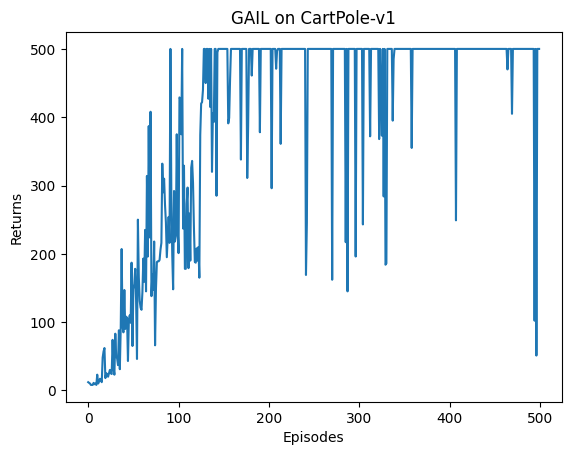

In [13]:
# 可视化
plt.plot(list(range(len(return_list))), return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on {}'.format(env_name))

在少量专家数据的情况下，GAIL 能获得更好的效果。

GAIL 的训练目标（拉近策略和专家的占用度量）**十分贴合模仿学习任务的目标**，避免了 行为克隆 中的复合误差问题；另一方面得益于 GAIL 训练中，**策略可以和环境交互出更多的数据**，以此训练判别器，进而生成对基于策略“量身定做”的指导奖励信号。

逆强化学习（IRL）也是模仿学习中的重要方法，它假设**环境的奖励函数**应该使得**专家轨迹获得最高的奖励值**，进而**学习背后的奖励函数**，最后基于该奖励函数做正向强化学习，从而得到模仿策略。